In [1]:
import sys
import os
import pathlib
sys.path.insert(0, '..')

import numpy as np

import control
import f16
import test_f16
import casadi as ca
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)

np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)
np.set_printoptions(linewidth=200)

In [2]:
p0 = f16.Parameters(xcg=0.3) # listed as -0.3, must be typo
theta_dot = 0.3
x0, u0 = f16.trim(s0=[0, 0, 0, 0, 0, 0], x=f16.State(VT=502), p=p0, phi_dot=0, theta_dot=0.3, psi_dot=0, gam=0)
ss = f16.linearize(x0, u0, p0)
ss

A:
[[  -0.02    7.88    0.      0.    -32.17    0.      0.     -0.65    0.      0.      0.      0.      0.4     0.      0.17    0.  ]
 [  -0.     -1.02    0.     -0.     -0.      0.     -0.      0.9    -0.      0.      0.      0.     -0.      0.     -0.      0.  ]
 [   0.      0.     -0.32    0.06    0.      0.      0.04    0.     -0.99    0.      0.     -0.     -0.      0.     -0.      0.  ]
 [   0.      0.      0.      0.      0.      0.      1.      0.      0.04    0.      0.      0.      0.      0.      0.      0.  ]
 [   0.      0.      0.     -0.      0.      0.      0.      1.     -0.      0.      0.      0.      0.      0.      0.      0.  ]
 [   0.      0.      0.      0.      0.      0.      0.      0.      1.      0.      0.      0.      0.      0.      0.      0.  ]
 [   0.      0.      0.1     0.      0.      0.     -3.67    0.      0.67    0.      0.     -0.      0.     -0.73    0.      0.13]
 [  -0.     -2.5     0.      0.      0.      0.      0.     -1.39   -0.      0. 

In [3]:
reduced_ss = ss.sub_system(x=['VT', 'alpha', 'theta', 'Q', 'power', 'beta', 'phi', 'P', 'R', 'elv_deg', 'ail_deg', 'rdr_deg'],
                           u=['thtl', 'elv_cmd_deg', 'ail_cmd_deg', 'rdr_cmd_deg']);
reduced_ss

A:
[[ -0.02   7.88 -32.17  -0.65   0.4    0.     0.     0.     0.     0.17   0.     0.  ]
 [ -0.    -1.02  -0.     0.9   -0.     0.    -0.    -0.    -0.    -0.     0.     0.  ]
 [  0.     0.     0.     1.     0.     0.    -0.     0.    -0.     0.     0.     0.  ]
 [ -0.    -2.5    0.    -1.39   0.     0.     0.     0.    -0.    -0.18   0.     0.  ]
 [  0.     0.     0.     0.    -1.     0.     0.     0.     0.     0.     0.     0.  ]
 [  0.     0.     0.     0.    -0.    -0.32   0.06   0.04  -0.99  -0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     1.     0.04   0.     0.     0.  ]
 [  0.     0.     0.     0.     0.     0.1    0.    -3.67   0.67   0.    -0.73   0.13]
 [  0.     0.     0.     0.     0.     0.93   0.    -0.03  -0.5    0.    -0.03  -0.06]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.   -20.2    0.     0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   -20.2    0.  ]
 [  0.     0.     0.     0.     0.     0

# Longitudinal Subsystem

In [4]:
lon_ss = ss.sub_system(x=['VT', 'alpha', 'theta', 'Q', 'power', 'elv_deg'], u=['thtl', 'elv_cmd_deg'])
lon_ss

A:
[[ -0.02   7.88 -32.17  -0.65   0.4    0.17]
 [ -0.    -1.02  -0.     0.9   -0.    -0.  ]
 [  0.     0.     0.     1.     0.     0.  ]
 [ -0.    -2.5    0.    -1.39   0.    -0.18]
 [  0.     0.     0.     0.    -1.     0.  ]
 [  0.     0.     0.     0.     0.   -20.2 ]]
B:
[[ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [ 0.    0.  ]
 [64.94  0.  ]
 [ 0.   20.2 ]]
C:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
D:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
dt:None
x:{'VT': 0, 'alpha': 1, 'theta': 2, 'Q': 3, 'power': 4, 'elv_deg': 5}
u:{'thtl': 0, 'elv_cmd_deg': 1}
y:{'VT': 0, 'alpha': 1, 'theta': 2, 'Q': 3, 'power': 4, 'elv_deg': 5}

In [5]:
np.linalg.eig(lon_ss.A)

(array([ -1.2 +1.49j,  -1.2 -1.49j,  -0.01+0.07j,  -0.01-0.07j,  -1.  +0.j  , -20.2 +0.j  ]),
 array([[ 0.98+0.j  ,  0.98-0.j  ,  1.  +0.j  ,  1.  -0.j  , -0.38+0.j  , -0.01+0.j  ],
        [ 0.09-0.02j,  0.09+0.02j, -0.  -0.j  , -0.  +0.j  ,  0.  +0.j  , -0.  +0.j  ],
        [ 0.06-0.05j,  0.06+0.05j, -0.  -0.j  , -0.  +0.j  ,  0.  +0.j  , -0.  +0.j  ],
        [ 0.01+0.15j,  0.01-0.15j,  0.  -0.j  ,  0.  +0.j  , -0.  +0.j  ,  0.01+0.j  ],
        [ 0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  0.  -0.j  ,  0.93+0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  1.  +0.j  ]]))

(-21.212099999999992, 1.010099999999996, -18.45228899216417, 18.45228899216417)

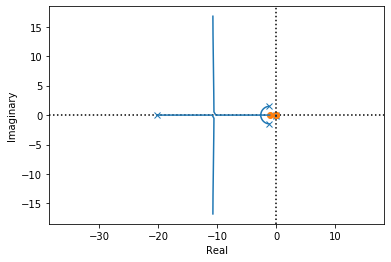

In [6]:
control.rlocus(-lon_ss.sub_system(lon_ss.x, ['elv_cmd_deg'], ['Q']).to_control(), kvect=np.linspace(0, 100, 1000));
plt.axis('equal')

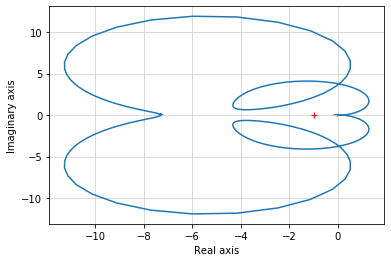

In [7]:
K = 100
G = K*ss.sub_system(lon_ss.x, ['elv_cmd_deg'], ['alpha']).to_control()
Gc = control.feedback(G, 1)


plt.figure()
control.nyquist(G, np.logspace(-4, 4, 1000));

Based on the above nyquist plot, what is N, the number of clockwise encirclements of -1?

Use this information and the poles of the open loop G (P), given below, to find the number
of unstable poles of the closed loop, which are the same as the zeros of the open loop (Z).

Z = N + P

In [8]:
control.pole(G)  # use to find P

array([ -1.2 +1.49j,  -1.2 -1.49j,  -0.01+0.07j,  -0.01-0.07j,  -1.  +0.j  , -20.2 +0.j  ])

Solution:

number of clockwise encirclements of -1: N = 1,
number of unstables poles of open loop: P = 0

number of unstables zeros of open loop: Z = 1

Therefore the number of unstable poles of the closed loop is Z, or 1. So the system is unstable.

In [9]:
control.pole(Gc)  # this tells you the answer

array([-19.44+0.j ,  -5.6 +0.j ,   2.44+0.j ,  -0.01+0.1j,  -0.01-0.1j,  -1.  +0.j ])

Here we can verify that Z = 1, Gc has one unstable pole.

What simple change could be made to K to make the closed loop system stable?

<Figure size 432x288 with 0 Axes>

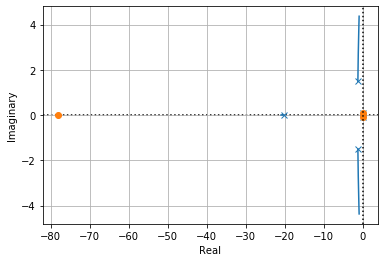

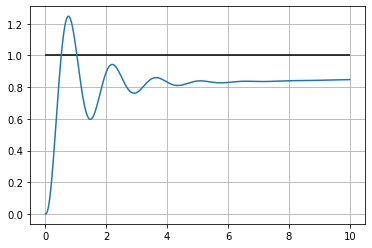

In [10]:
plt.figure()
control.rlocus(-G, kvect=np.linspace(0, 1, 1000));
plt.grid()

plt.figure()
t, y = control.step_response(control.feedback(-G, 1), T=np.linspace(0, 10, 1000));
plt.plot(t, y)
plt.hlines(1, 0, 10)
plt.grid()

# Lateral Subsystem

In [11]:
lat_ss = ss.sub_system(['beta', 'phi', 'P', 'R', 'ail_deg', 'rdr_deg'], ['ail_cmd_deg', 'rdr_cmd_deg'])
lat_ss

A:
[[ -0.32   0.06   0.04  -0.99   0.     0.  ]
 [  0.     0.     1.     0.04   0.     0.  ]
 [  0.1    0.    -3.67   0.67  -0.73   0.13]
 [  0.93   0.    -0.03  -0.5   -0.03  -0.06]
 [  0.     0.     0.     0.   -20.2    0.  ]
 [  0.     0.     0.     0.     0.   -20.2 ]]
B:
[[ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [ 0.   0. ]
 [20.2  0. ]
 [ 0.  20.2]]
C:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
D:
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
dt:None
x:{'beta': 0, 'phi': 1, 'P': 2, 'R': 3, 'ail_deg': 4, 'rdr_deg': 5}
u:{'ail_cmd_deg': 0, 'rdr_cmd_deg': 1}
y:{'beta': 0, 'phi': 1, 'P': 2, 'R': 3, 'ail_deg': 4, 'rdr_deg': 5}

In [12]:
np.linalg.eig(lat_ss.A)

(array([ -3.67+0.j  ,  -0.42+0.95j,  -0.42-0.95j,   0.01+0.j  , -20.2 +0.j  , -20.2 +0.j  ]),
 array([[ 0.  +0.j  ,  0.7 +0.j  ,  0.7 -0.j  , -0.03+0.j  , -0.  +0.j  ,  0.  +0.j  ],
        [ 0.26+0.j  , -0.14+0.07j, -0.14-0.07j, -1.  +0.j  , -0.  +0.j  ,  0.  +0.j  ],
        [-0.96+0.j  , -0.01-0.14j, -0.01+0.14j, -0.01+0.j  ,  0.04+0.j  , -0.01+0.j  ],
        [-0.01+0.j  ,  0.06-0.68j,  0.06+0.68j, -0.05+0.j  ,  0.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  0.  +0.j  ,  1.  +0.j  ,  0.  +0.j  ],
        [ 0.  +0.j  ,  0.  -0.j  ,  0.  +0.j  ,  0.  +0.j  ,  0.  +0.j  ,  1.  +0.j  ]]))

1 states have been removed from the model


<Figure size 432x288 with 0 Axes>

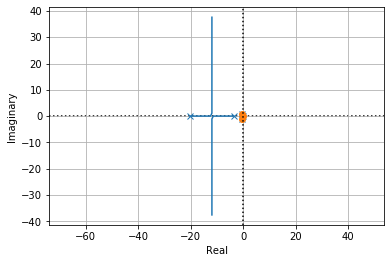

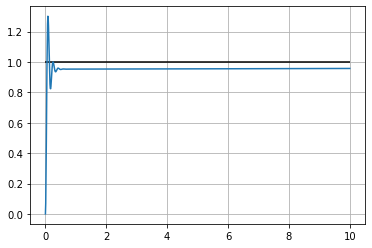

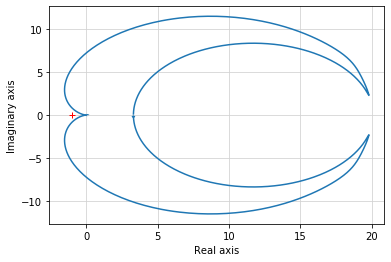

In [13]:
K2 = -100
G2 = K2*ss.sub_system(lat_ss.x, ['ail_cmd_deg'], ['P']).to_control();
G2c = control.minreal(control.feedback(G2, 1))

plt.figure()
control.rlocus(G2, kvect=np.linspace(0, 1, 1000));
plt.grid()
plt.axis('equal');

plt.figure()
t, y = control.step_response(G2c, T=np.linspace(0, 10, 1000));
plt.plot(t, y)
plt.hlines(1, 0, 10)
plt.grid()

plt.figure()
control.nyquist(G2, np.logspace(-4, 4, 1000));